In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

from tabulate import tabulate
from time import time

import pystan
from pystan import StanModel

from sklearn import cross_validation
from scipy.stats import gaussian_kde

In [2]:
# import acs Data
# NY州のThe 2010 American Community Surveyデータ

df_acs = pd.read_table("http://jaredlander.com/data/acs_ny.csv", sep=",", header=0)
df_acs.head(5)

,Acres,FamilyIncome,FamilyType,NumBedrooms,NumChildren,NumPeople,NumRooms,NumUnits,NumVehicles,NumWorkers,OwnRent,YearBuilt,HouseCosts,ElectricBill,FoodStamp,HeatingFuel,Insurance,Language
0,1-10,150,Married,4,1,3,9,Single detached,1,0,Mortgage,1950-1959,1800,90,No,Gas,2500,English
1,1-10,180,Female Head,3,2,4,6,Single detached,2,0,Rented,Before 1939,850,90,No,Oil,0,English
2,1-10,280,Female Head,4,0,2,8,Single detached,3,1,Mortgage,2000-2004,2600,260,No,Oil,6600,Other European
3,1-10,330,Female Head,2,1,2,4,Single detached,1,0,Rented,1950-1959,1800,140,No,Oil,0,English
4,1-10,330,Male Head,3,1,2,5,Single attached,1,0,Mortgage,Before 1939,860,150,No,Gas,660,Spanish


In [9]:
dum_ftype = pd.get_dummies(df_acs["FamilyType"])
dum_own = pd.get_dummies(df_acs["OwnRent"])

In [10]:
dum_own.head()

,Mortgage,Outright,Rented
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,1,0,0


In [11]:
df_acs = pd.concat((df_acs, dum_ftype), axis=1)
df_acs = pd.concat((df_acs, dum_own), axis=1)
df_acs.head()

,Acres,FamilyIncome,FamilyType,NumBedrooms,NumChildren,NumPeople,NumRooms,NumUnits,NumVehicles,NumWorkers,...,FoodStamp,HeatingFuel,Insurance,Language,Female Head,Male Head,Married,Mortgage,Outright,Rented
0,1-10,150,Married,4,1,3,9,Single detached,1,0,...,No,Gas,2500,English,0,0,1,1,0,0
1,1-10,180,Female Head,3,2,4,6,Single detached,2,0,...,No,Oil,0,English,1,0,0,0,0,1
2,1-10,280,Female Head,4,0,2,8,Single detached,3,1,...,No,Oil,6600,Other European,1,0,0,1,0,0
3,1-10,330,Female Head,2,1,2,4,Single detached,1,0,...,No,Oil,0,English,1,0,0,0,0,1
4,1-10,330,Male Head,3,1,2,5,Single attached,1,0,...,No,Gas,660,Spanish,0,1,0,1,0,0


In [3]:
#df_acs['FamilyType'] = df_acs.FamilyType.map( {'Married': 1, 'Female Head': 2, 'Male Head':3} ).astype(int)
#df_acs['OwnRent'] = df_acs.OwnRent.map( {'Mortgage': 1, 'Rented': 2, 'Outright': 3} ).astype(int)

In [12]:
k = df_acs.keys()
k

Index([u'Acres', u'FamilyIncome', u'FamilyType', u'NumBedrooms',
       u'NumChildren', u'NumPeople', u'NumRooms', u'NumUnits', u'NumVehicles',
       u'NumWorkers', u'OwnRent', u'YearBuilt', u'HouseCosts', u'ElectricBill',
       u'FoodStamp', u'HeatingFuel', u'Insurance', u'Language', u'Female Head',
       u'Male Head', u'Married', u'Mortgage', u'Outright', u'Rented'],
      dtype='object')

In [18]:
k[23]

'Rented'

In [20]:
target = df_acs.NumChildren
data   = df_acs.ix[:,[1, 18, 19, 20, 21, 22, 23]]

In [21]:
data.head()

,FamilyIncome,Female Head,Male Head,Married,Mortgage,Outright,Rented
0,150,0,0,1,1,0,0
1,180,1,0,0,0,0,1
2,280,1,0,0,1,0,0
3,330,1,0,0,0,0,1
4,330,0,1,0,1,0,0


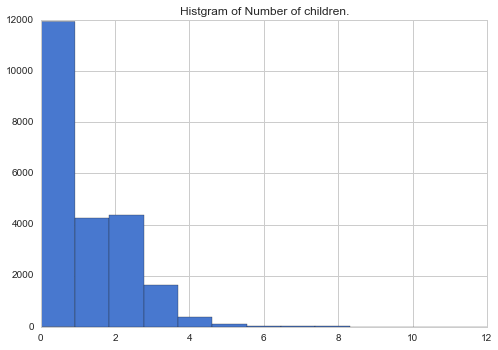

In [22]:
plt.title("Histgram of Number of children.")
df_acs.NumChildren.hist(bins=13)

In [24]:
# 訓練データ(80%), テストデータ(20%)に分割する
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.2, random_state=None)

print [d.shape for d in [X_train, X_test, y_train, y_test]]

[(18196, 7), (4549, 7), (18196,), (4549,)]


In [25]:
dat = {'N': X_train.shape[0], 'M': data.shape[1], 'X': X_train, 'y': y_train}

In [30]:
X_train.head()

,FamilyIncome,Female Head,Male Head,Married,Mortgage,Outright,Rented
17121,131700,0,0,1,1,0,0
77,11000,0,1,0,1,0,0
21742,300,1,0,0,0,0,1
16669,125400,0,0,1,1,0,0
11507,75000,0,0,1,0,0,1


In [57]:
code = """
    data {
        int<lower=0> N;
        int<lower=0> M;
        matrix[N, M] X;
        int<lower=0,upper=20> y[N];
    } parameters {
        real beta0;
        vector[M] beta; 
    } transformed parameters  {
        real lp[N];
        real <lower=0> mu[N]; 
        for (i in 1:N) {
            mu[i] <- exp(beta0 + dot_product(X[i] , beta));
        }
    } model {
        y ~ poisson(mu);
    }"""

In [58]:
%time stm = StanModel(model_code=code)

CPU times: user 1.79 s, sys: 247 ms, total: 2.04 s
Wall time: 16.2 s


In [59]:
n_itr = 2000
n_warmup = 500
chains = 2

%time fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)
la    = fit.extract(permuted=True)  # return a dictionary of arrays
names = fit.model_pars 

n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])

RuntimeError: Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.


Initialization between (-2, 2) failed after 100 attempts. 
 Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model.


In [ ]:
print fit